# Meshing a coal seam using a PolyData

We only work on the first polygon for now...

In [1]:
import geopandas as gpd
import pyvista as pv
import pyacvd
from shapely.geometry import Polygon
import numpy as np

/home/su530201/.local/share/virtualenvs/gsdma_2021-CLBGPK-k/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## open and read the file

In [2]:
gdf = gpd.read_file('../../../../data/example.gpkg', layer = 'Parties exploitées - Caillette')

#open and read the file

## print the head of the file

In [3]:
gdf.head()
# print the head of the file

,Année,geometry
0,1941,"POLYGON Z ((154613.672 123991.170 -663.000, 15..."
1,1942,"POLYGON Z ((154816.546 123955.316 -671.100, 15..."
2,1939,"POLYGON Z ((154912.246 123824.192 -686.800, 15..."
3,1942,"POLYGON Z ((154868.618 123744.141 -698.900, 15..."
4,1938,"POLYGON Z ((154949.664 123925.004 -679.300, 15..."


In [4]:
row = gdf.loc[4,:]

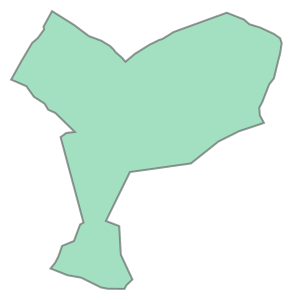

In [5]:
row.geometry

## creating a list with the exterior coords

In [6]:
#creating a list with the exterior coords
if isinstance(row.geometry, Polygon):
                number_of_vertices = len(list(row.geometry.exterior.coords))
                if row.geometry.has_z:  # TODO: Can we handle Polygons with holes?
                    vertices = list(row.geometry.exterior.coords)
                else:
                    vertices = zip(row.geometry.exterior.xy[0], row.geometry.exterior.xy[1],
                                   itertools.repeat(row[elevation]))

In [7]:
#converting in a numpy array
vertices = np.array(vertices)

## creating a list with index corresponding to each faces, with the number of faces in the first position

In [8]:
#creating a list with index corresponding to each faces, with the number of faces in the first position
face = [number_of_vertices-1]
face.extend([i for i in range(number_of_vertices-1)])
face = np.array(face)
face

array([65,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

## creating the first polygon and meshing it with delaunay triangle

In [9]:
#creating the first polygon and meshing it with delaunay triangle
polygon = pv.PolyData(vertices, face)
polygon.point_data['Elevation'] = vertices.T[2]
polygon_d = polygon.delaunay_2d()

In [10]:
polygon_d = polygon_d.subdivide(3, subfilter='linear')

In [11]:
polygon_d.plot(jupyter_backend='panel', color='w', style='surface', interpolate_before_map=True,
           scalar_bar_args={'title': 'Elevation'},show_edges=True
           )

In [12]:
#
clipped = polygon_d.clip_surface(polygon.extrude([0.,0.,500.]).transform(np.array([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,-250.],[0.,0.,0.,1.]])), invert=False).decimate_pro(0.75)

In [13]:
transform_matrix = np.array([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, -250],
                             [0, 0, 0, 1]])

/home/su530201/.local/share/virtualenvs/gsdma_2021-CLBGPK-k/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


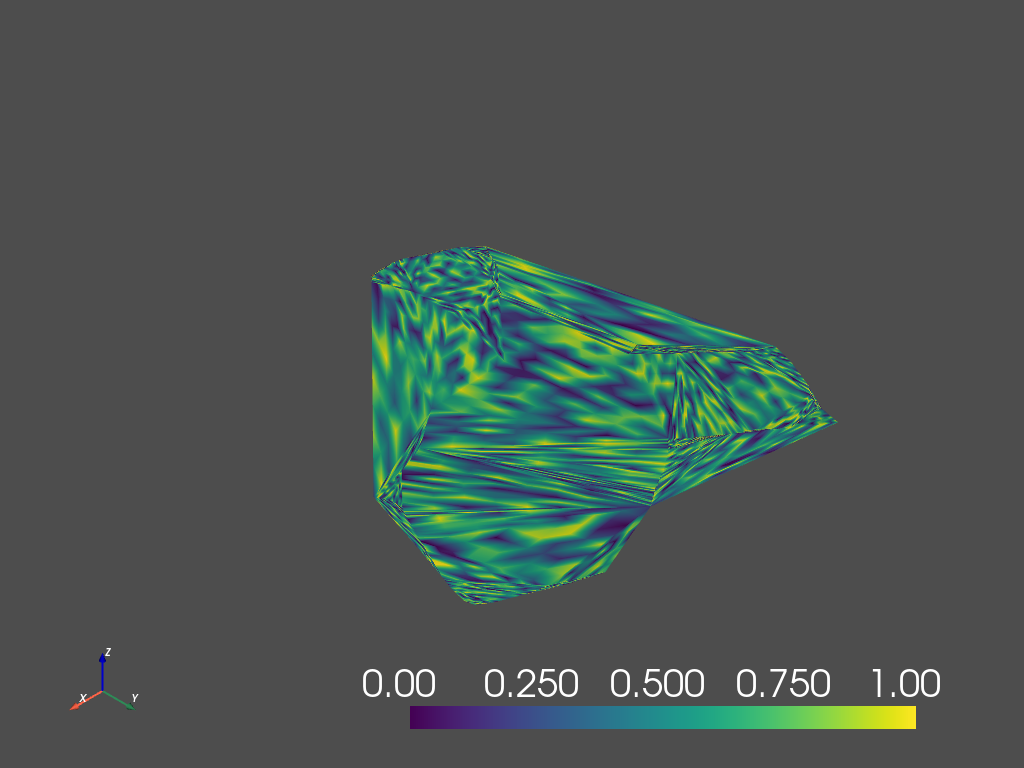

In [14]:
cluster = pyacvd.Clustering(polygon_d)
# mesh is not dense enough for uniform remeshing
cluster.cluster(20000, maxiter=2000)
cluster.plot()

## trial to extrude a polygon

In [16]:
pl = pv.Plotter()
#creating a mesh
pl.add_mesh(clipped.smooth(n_iter=30000, boundary_smoothing=False).decimate_pro(0.5), style='surface')
#extrude the form (plane)
pl.add_mesh(polygon.extrude([0,0,500]).transform(transform_matrix), opacity=0.5)
pl.add_mesh(polygon, style='wireframe', color='k')
pl.show(jupyter_backend='panel')

In [17]:
# remesh
remesh = cluster.create_mesh()
remesh = remesh.clip_surface(polygon.extrude([0.,0.,500.]).transform(transform_matrix), invert=False).clean().decimate_pro(0.75).smooth(n_iter=100000, boundary_smoothing=False)

/home/su530201/.local/share/virtualenvs/gsdma_2021-CLBGPK-k/lib/python3.8/site-packages/pyvista/core/dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
/home/su530201/.local/share/virtualenvs/gsdma_2021-CLBGPK-k/lib/python3.8/site-packages/pyvista/core/dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


In [18]:
# plot uniformly remeshed 3D surface
remesh.transform(transform_matrix).plot(jupyter_backend='panel', show_edges=True)

In [19]:
# extruding the 3D surface
pl = pv.Plotter(window_size=(1024,480))
pl.add_mesh(remesh.extrude([0,0,10], capping=True), color='r', opacity=0.5, edge_color='darkgrey', show_edges=True)
pl.add_mesh(clipped, color='b')
pl.add_axes()
pl.show(jupyter_backend='panel')

In [20]:
remesh.point_data['Elevation'] = remesh.points[:,2]

## create a regular mesh

In [21]:
import pygmsh
import gmsh
import pyvista as pv
import meshio

In [26]:
with pygmsh.geo.Geometry() as geom:
    lcar =1
    p1= geom.add_point( [0.0,0.0,0.0] ,lcar)
    p2= geom.add_point( [10.0,0.0,0.0] ,lcar)
    p3= geom.add_point( [10.0,10.0,0.0] ,lcar)
    p4= geom.add_point( [0.0,10.0,0.0] ,lcar)
    l1= geom.add_line( p1, p2)
    l2= geom.add_line( p2, p3)
    l3= geom.add_line( p3, p4)
    l4= geom.add_line( p4, p1)
    L1= geom.add_curve_loop( [l1,l2,l3,l4])
    s1= geom.add_surface(L1)
    
    geom.set_transfinite_curve(l1, mesh_type='Progression', num_nodes=11,coeff=1.)
    geom.set_transfinite_curve(l2, mesh_type='Progression', num_nodes=11,coeff=1.)
    geom.set_transfinite_curve(l3, mesh_type='Progression', num_nodes=11,coeff=1.)
    geom.set_transfinite_curve(l4, mesh_type='Progression', num_nodes=11,coeff=1.)
    geom.set_transfinite_surface(s1, arrangement='left', corner_pts=(p1,p2,p3,p4))
    geom.set_recombined_surfaces([s1])

    #mesh=geom.generate_mesh(dim=2)
    
    V1=geom.extrude(s1, [0.0, 0.0, 10.0],num_layers=5,recombine=True)
    #points, cells, point_data, cell_data, field_data = geom.generate_mesh()
    #geom.set_transfinite_volume(V1,
    
    mesh=geom.generate_mesh()
    
    
    mesh.write('./tmp_files/test_1.vtk')
  

In [27]:
grid = pv.read('./tmp_files/test_1.vtk')
grid.plot(jupyter_backend='panel',show_scalar_bar=False, show_axes=False,show_edges=True)

In [28]:
grid

UnstructuredGrid,Information
N Cells,1008
N Points,726
X Bounds,"0.000e+00, 1.000e+01"
Y Bounds,"0.000e+00, 1.000e+01"
Z Bounds,"0.000e+00, 1.000e+01"
N Arrays,0


## Interactive representation

In [29]:
dargs = dict(scalars='Elevation', cmap='rainbow', show_edges=True, window_size=(1024,480))

remesh.smooth(n_iter=200, boundary_smoothing=False).plot(jupyter_backend='panel', color='w', style='surface', interpolate_before_map=True,
           scalar_bar_args={'title': 'Elevation'},
           **dargs)

## Static representation for thumbnail

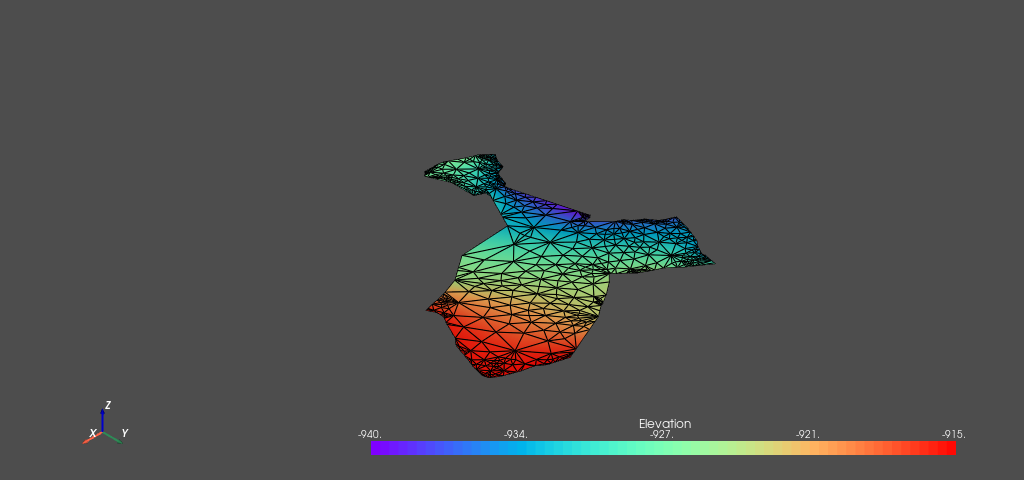

In [30]:
dargs = dict(scalars='Elevation', cmap='rainbow', show_edges=True, window_size=(1024,480))

remesh.plot(jupyter_backend='static', color='w', style='surface', interpolate_before_map=True,
        scalar_bar_args={'title': 'Elevation'}, **dargs)